# Stroke Prediction Dataset

## 0. Описание задачи

Этот датасет используется для прогнозирования вероятности инсульта у пациента на основе входных параметров, таких как пол, возраст, различные заболевания, индекс массы тела и статус курения. Каждая строка в данных содержит информацию о пациенте.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

## 1. Чтение данных

In [2]:
file = "healthcare-dataset-stroke-data.csv"
data_raw = pd.read_csv(file)

In [3]:
data_raw.shape

(5110, 12)

## Визуализация данных и вычисление характеристик

In [4]:
data_raw

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Вычисляем основные характеристики

In [5]:
data_raw.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Из таблицы видно, что самому старшему пациенту 82 года, самому младшему - меньше года.
Максимальное и минимальное значения bmi показывает, что в данных присутствуют пациенты с 3-ей степенью ожирения, 
а также с выраженным дефицитом массы тела.
Так как данные не сбалансированы, у большинства пациентов, представленных в датасете не было инсульта.
Средний возраст - 43 года.

mean - среднее значение. Выведем его отдельно.

In [6]:
data_raw.mean()

id                   36517.829354
age                     43.226614
hypertension             0.097456
heart_disease            0.054012
avg_glucose_level      106.147677
bmi                     28.893237
stroke                   0.048728
dtype: float64

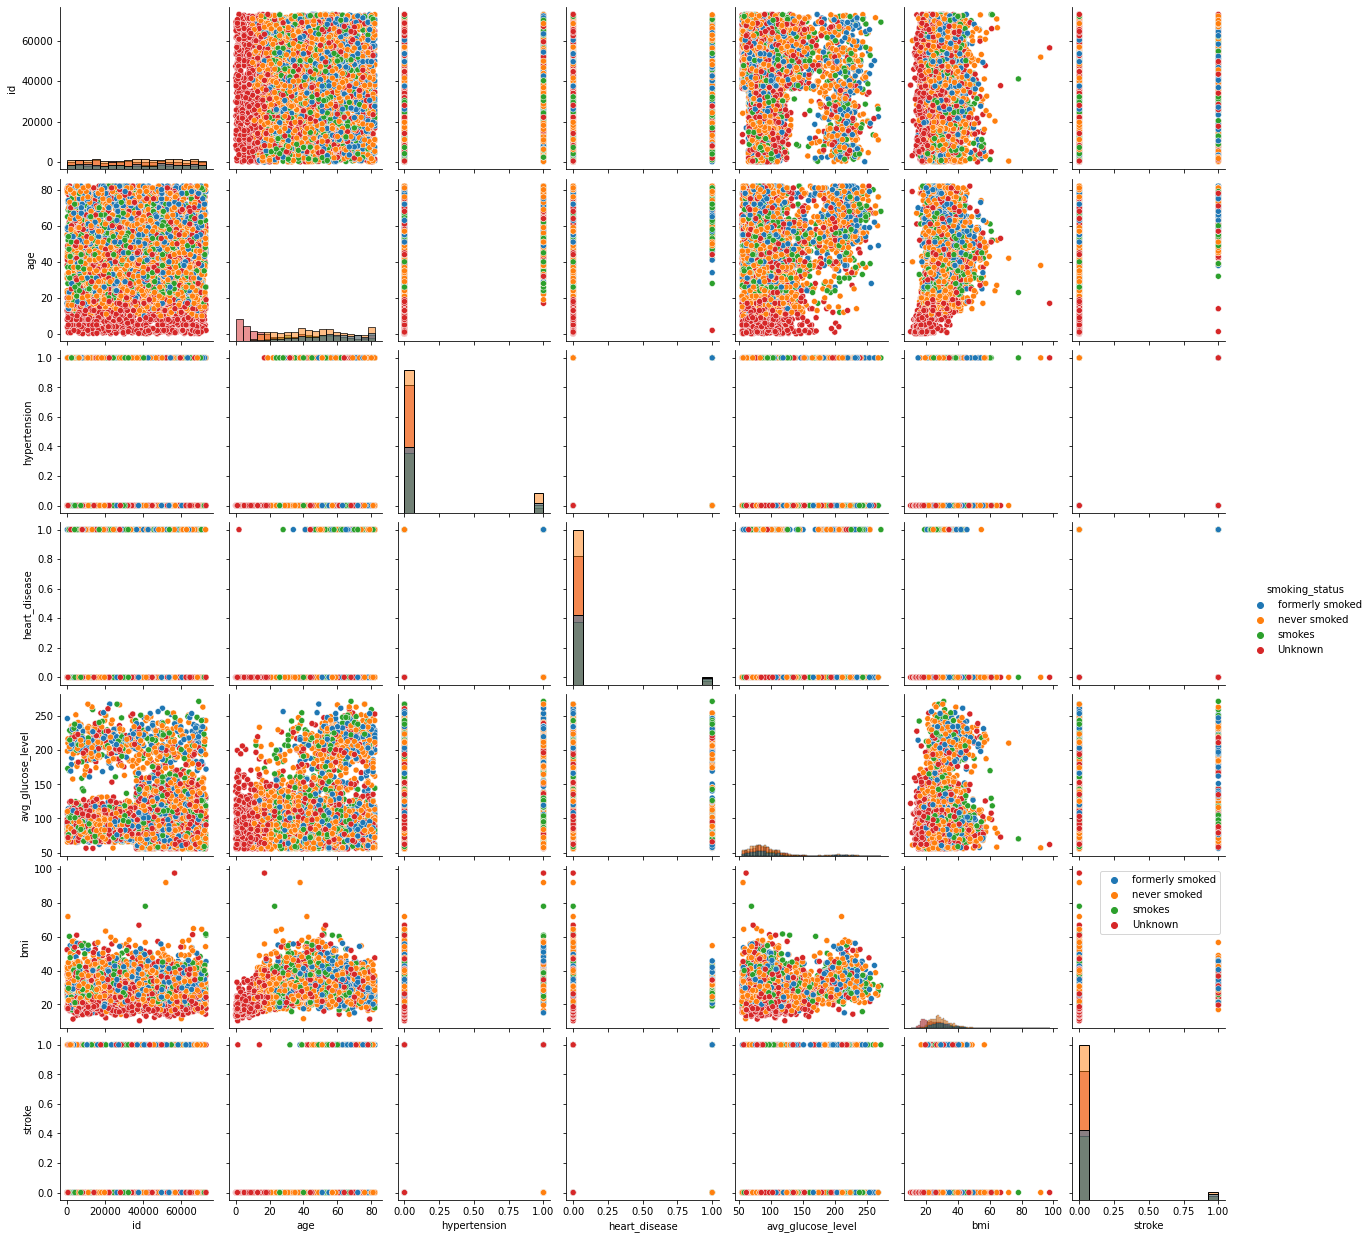

In [7]:
sns.pairplot(data_raw, hue='smoking_status', diag_kind='hist')
plt.legend()
pass

На рисунках выше изображен разброс данных

In [8]:
corr_mat = data_raw.corr()
corr_mat

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


В таблице выше вычислена кореляционная матрица. Визуализируем её:

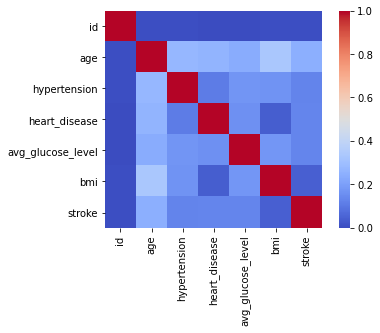

In [9]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Из таблицы видно, что индекс массы тела (bmi) и возраст (age) пациента кореллируют друг с другом. Также возраст кореллирует с остальными признаками больше, чем эти признаки друг с другом. id же, очевидно, не кореллирует ни с одним признаком.

## 3. Обработка пропущенных значений

In [10]:
data_raw.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [11]:
data_raw.fillna(data_raw.median(axis = 0), axis=0 , inplace=True)

In [12]:
data_raw.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## 4. Обработка категориальных признаков

In [13]:
data_raw['ever_married'] = pd.factorize(data_raw['ever_married'])[0]

In [14]:
gender_dummies = pd.get_dummies(data_raw['gender'])
data_raw = pd.concat((data_raw, gender_dummies), axis=1)
data_raw = data_raw.drop(['gender'], axis=1)

In [15]:
data_raw

,id,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,Female,Male,Other
0,9046,67.0,0,1,0,Private,Urban,228.69,36.6,formerly smoked,1,0,1,0
1,51676,61.0,0,0,0,Self-employed,Rural,202.21,28.1,never smoked,1,1,0,0
2,31112,80.0,0,1,0,Private,Rural,105.92,32.5,never smoked,1,0,1,0
3,60182,49.0,0,0,0,Private,Urban,171.23,34.4,smokes,1,1,0,0
4,1665,79.0,1,0,0,Self-employed,Rural,174.12,24.0,never smoked,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,0,Private,Urban,83.75,28.1,never smoked,0,1,0,0
5106,44873,81.0,0,0,0,Self-employed,Urban,125.20,40.0,never smoked,0,1,0,0
5107,19723,35.0,0,0,0,Self-employed,Rural,82.99,30.6,never smoked,0,1,0,0
5108,37544,51.0,0,0,0,Private,Rural,166.29,25.6,formerly smoked,0,0,1,0


In [16]:
work_dummies = pd.get_dummies(data_raw['work_type'])
data_raw = pd.concat((data_raw, work_dummies), axis=1)
data_raw = data_raw.drop(['work_type'], axis=1)

res_dummies = pd.get_dummies(data_raw['Residence_type'])
data_raw = pd.concat((data_raw, res_dummies), axis=1)
data_raw = data_raw.drop(['Residence_type'], axis=1)

smoking_dummies = pd.get_dummies(data_raw['smoking_status'])
data_raw = pd.concat((data_raw, smoking_dummies), axis=1)
data_raw = data_raw.drop(['smoking_status'], axis=1)

In [17]:
data_raw

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,Female,Male,...,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown,formerly smoked,never smoked,smokes
0,9046,67.0,0,1,0,228.69,36.6,1,0,1,...,0,1,0,0,0,1,0,1,0,0
1,51676,61.0,0,0,0,202.21,28.1,1,1,0,...,0,0,1,0,1,0,0,0,1,0
2,31112,80.0,0,1,0,105.92,32.5,1,0,1,...,0,1,0,0,1,0,0,0,1,0
3,60182,49.0,0,0,0,171.23,34.4,1,1,0,...,0,1,0,0,0,1,0,0,0,1
4,1665,79.0,1,0,0,174.12,24.0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,80.0,1,0,0,83.75,28.1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5106,44873,81.0,0,0,0,125.20,40.0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
5107,19723,35.0,0,0,0,82.99,30.6,0,1,0,...,0,0,1,0,1,0,0,0,1,0
5108,37544,51.0,0,0,0,166.29,25.6,0,0,1,...,0,1,0,0,1,0,0,1,0,0


## 5. Нормализация

In [18]:
data_stand = (data_raw - data_raw.mean(axis = 0))/data_raw.std(axis = 0)
data_stand.describe()

,id,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,Female,Male,...,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown,formerly smoked,never smoked,smokes
count,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,...,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03,5.110000e+03
mean,-1.278277e-16,-7.276211e-16,3.834984e-15,3.465047e-16,2.588493e-16,3.674925e-15,-9.830601e-15,-8.842731e-15,2.038161e-16,4.016357e-16,...,-2.471658e-16,2.277369e-16,2.775558e-16,-2.316912e-15,4.180826e-16,-4.297932e-16,-1.521027e-15,5.802382e-16,9.937691e-17,-5.552201e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.722489e+00,-1.908074e+00,-3.285697e-01,-2.389234e-01,-7.238134e-01,-1.126848e+00,-2.410791e+00,-2.263051e-01,-1.189394e+00,-8.402611e-01,...,-6.574993e-02,-1.156897e+00,-4.368378e-01,-3.940737e-01,-9.839834e-01,-1.016078e+00,-6.579463e-01,-4.576314e-01,-7.666993e-01,-4.272714e-01
25%,-8.872898e-01,-8.060363e-01,-3.285697e-01,-2.389234e-01,-7.238134e-01,-6.382598e-01,-6.574445e-01,-2.263051e-01,-1.189394e+00,-8.402611e-01,...,-6.574993e-02,-1.156897e+00,-4.368378e-01,-3.940737e-01,-9.839834e-01,-1.016078e+00,-6.579463e-01,-4.576314e-01,-7.666993e-01,-4.272714e-01
50%,1.957169e-02,7.842450e-02,-3.285697e-01,-2.389234e-01,-7.238134e-01,-3.149637e-01,-9.897124e-02,-2.263051e-01,8.406001e-01,-8.402611e-01,...,-6.574993e-02,8.642120e-01,-4.368378e-01,-3.940737e-01,-9.839834e-01,9.839834e-01,-6.579463e-01,-4.576314e-01,-7.666993e-01,-4.272714e-01
75%,8.583503e-01,7.859932e-01,-3.285697e-01,-2.389234e-01,1.381301e+00,1.753909e-01,5.114531e-01,-2.263051e-01,8.406001e-01,1.189873e+00,...,-6.574993e-02,8.642120e-01,-4.368378e-01,-3.940737e-01,1.016078e+00,9.839834e-01,1.519583e+00,-4.576314e-01,1.304037e+00,-4.272714e-01
max,1.721135e+00,1.714677e+00,3.042899e+00,4.184622e+00,1.381301e+00,3.656787e+00,8.927516e+00,4.417948e+00,8.406001e-01,1.189873e+00,...,1.520617e+01,8.642120e-01,2.288731e+00,2.537100e+00,1.016078e+00,9.839834e-01,1.519583e+00,2.184737e+00,1.304037e+00,2.339975e+00


## 6. Разбиение данных на обучающую и тестовую выборки

In [19]:
data_stand.columns

Index(['id', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'Female', 'Male', 'Other',
       'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children',
       'Rural', 'Urban', 'Unknown', 'formerly smoked', 'never smoked',
       'smokes'],
      dtype='object')

In [20]:
X = data_stand.drop(['stroke', 'id'], axis=1)
y = data_raw['stroke']

Убрали id так как от него не должен зависеть результат

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 47)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(3832, 1278)

## 7. Классификатор ближайших соседей

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

## 8. Ошибки на обучающей и тестовой выборках

In [23]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.04592901878914405

In [24]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)

In [25]:
err_test

0.053208137715179966

In [26]:
print(confusion_matrix(y_test,y_test_predict))

[[1208    1]
 [  67    2]]


при количестве соседей 7, тестовая ошибка наименьшая

## Общие выводы
### Так как датасет несбалансирован (инсульт у примерно 5% процентов), в тренировочную выборку могли попасть только люди без инсульта, то есть модель может не научиться предсказывать инсульт.

# Нейронная сеть

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [28]:
%%time
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Wall time: 49.6 s


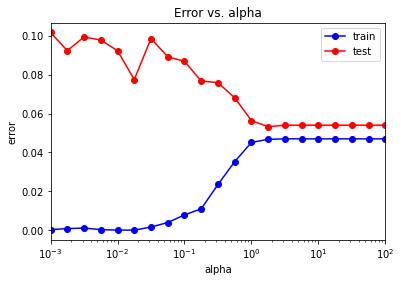

In [29]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

#### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

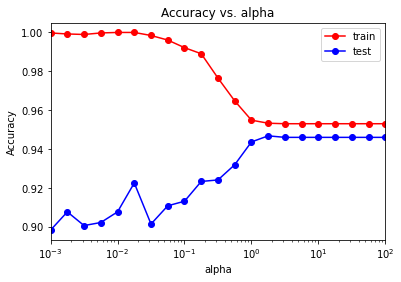

In [30]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

##### Минимальное значение ошибки:

In [31]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.053208137715179966


##### Оптимальное значение alpha:

In [32]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[1.77827941]


In [33]:
alpha_opt = alpha_opt[0]

In [34]:
alpha_opt

1.7782794100389228

#### Классификатор при найденном оптимальном значении alpha:

In [35]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.046711899791231734
0.053208137715179966


### Рассмотрим как у нас менялась метрика в зависимости от числа нейронов:

In [36]:
%%time
neuron_arr = np.linspace(1, 100, 60, endpoint=True, dtype=int)
test_err = []
train_err = []
train_acc = []
test_acc = []

for neuron in neuron_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))


Wall time: 41.6 s


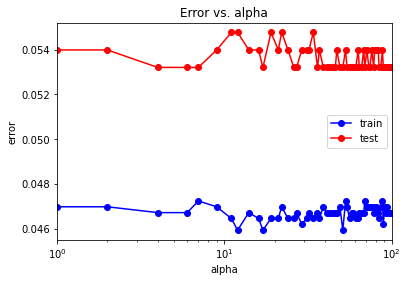

In [37]:
plt.semilogx(neuron_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neuron_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

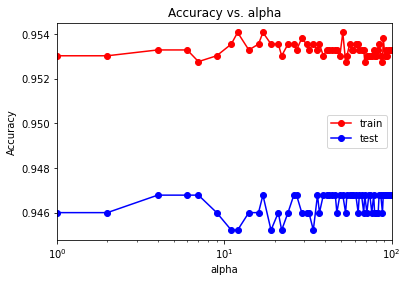

In [38]:
plt.semilogx(neuron_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(neuron_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

In [39]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.04592901878914405 0.053208137715179966


In [40]:
neuron_opt = neuron_arr[test_err == min_test_err]
neuron_opt = neuron_opt[0]
print("Оптимальное число нейронов:", neuron_opt)

Оптимальное число нейронов: 4


#### Классификатор при найденном оптимальном числе нейронов

In [41]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.046711899791231734
0.053208137715179966


#### Найдем оптимальное число нейронов на втором слое:

In [42]:
%%time
neuron_arr = np.linspace(1, 100, 60, endpoint=True, dtype=int)
test_err = []
train_err = []
train_acc = []
test_acc = []

for neuron in neuron_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt, neuron), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Wall time: 45.5 s


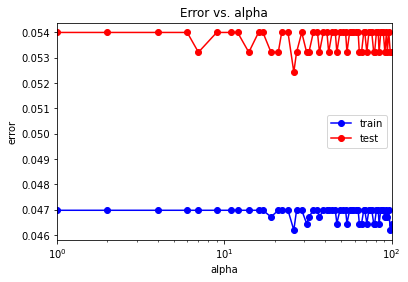

In [43]:
plt.semilogx(neuron_arr, train_err, 'b-o', label = 'train')
plt.semilogx(neuron_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

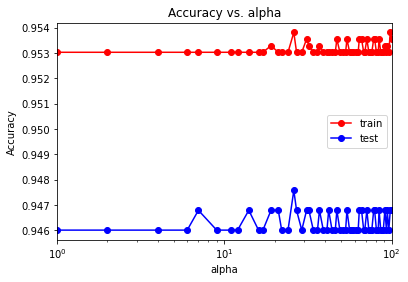

In [44]:
plt.semilogx(neuron_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(neuron_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

In [45]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.046189979123173276 0.05242566510172144


In [46]:
neuron_opt2 = neuron_arr[test_err == min_test_err]
neuron_opt2 = neuron_opt2[0]
print("Оптимальное число нейронов:", neuron_opt2)

Оптимальное число нейронов: 26


##### Классификатор при найденном оптимальном числе нейронов:

In [47]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.046711899791231734
0.053208137715179966


In [48]:
print(confusion_matrix(y_test,y_test_pred))

[[1209    0]
 [  68    1]]


## Другие классификаторы

#### Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier()
randf.fit(X_train, y_train)
train_err = np.mean(y_train != randf.predict(X_train))
test_err  = np.mean(y_test  != randf.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test,randf.predict(X_test)))

0.0 0.0539906103286385
[[1209    0]
 [  69    0]]


#### Decision Tree

In [50]:
from sklearn.tree import DecisionTreeClassifier
dect = DecisionTreeClassifier()
dect.fit(X_train, y_train)
train_err = np.mean(y_train != dect.predict(X_train))
test_err  = np.mean(y_test  != dect.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, dect.predict(X_test)))

0.0 0.09937402190923318
[[1144   65]
 [  62    7]]


#### Ada Boost

In [51]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
train_err = np.mean(y_train != clf.predict(X_train))
test_err  = np.mean(y_test  != clf.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, clf.predict(X_test)))

0.04697286012526096 0.05555555555555555
[[1204    5]
 [  66    3]]


#### SVM

In [52]:
from sklearn import svm
svmc = svm.SVC()
svmc.fit(X_train, y_train)
train_err = np.mean(y_train != svmc.predict(X_train))
test_err  = np.mean(y_test  != svmc.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, svmc.predict(X_test)))

0.04697286012526096 0.0539906103286385
[[1209    0]
 [  69    0]]


##### Вывод:

###### Метод Random Forest показывает наименьшую ошибку

### Балансировка

((4380, 20), (4380, 1))

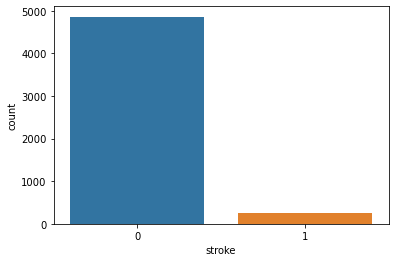

In [53]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
sns.countplot(x = 'stroke', data = data_raw)
smote = SMOTE(sampling_strategy=0.2)
X_new, y_new = smote.fit_resample(X_train, y_train.values.ravel())
X_new, y_new = RandomUnderSampler(sampling_strategy=0.2).fit_resample(X_new, y_new)
X_new = pd.DataFrame(X_new)
y_new = pd.DataFrame(y_new)

(X_new.shape,y_new.shape)

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_new, y_new.values.ravel())

KNeighborsClassifier(n_neighbors=7)

In [55]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.06732776617954071

In [56]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.11189358372456965

In [57]:
print(confusion_matrix(y_test, knn.predict(X_test)))

[[1122   87]
 [  56   13]]


#### Другие классификаторы на сбалансированных данных

In [58]:
randf = RandomForestClassifier()
randf.fit(X_new, y_new.values.ravel())
train_err = np.mean(y_new.values.ravel() != randf.predict(X_new))
test_err  = np.mean(y_test  != randf.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, randf.predict(X_test)))

0.0 0.07042253521126761
[[1185   24]
 [  66    3]]


In [59]:
from sklearn.tree import DecisionTreeClassifier
dect = DecisionTreeClassifier()
dect.fit(X_new, y_new.values.ravel())
train_err = np.mean(y_new.values.ravel() != dect.predict(X_new))
test_err  = np.mean(y_test  != dect.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, dect.predict(X_test)))

0.0 0.13067292644757433
[[1099  110]
 [  57   12]]


In [60]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=42)
clf.fit(X_new, y_new.values.ravel())
train_err = np.mean(y_new.values.ravel() != clf.predict(X_new))
test_err  = np.mean(y_test  != clf.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, clf.predict(X_test)))

0.10114155251141553 0.06572769953051644
[[1182   27]
 [  57   12]]


In [61]:
from sklearn import svm
svmc = svm.SVC()
svmc.fit(X_new, y_new.values.ravel())
train_err = np.mean(y_new.values.ravel() != svmc.predict(X_new))
test_err  = np.mean(y_test  != svmc.predict(X_test))
print(train_err, test_err)
print(confusion_matrix(y_test, svmc.predict(X_test)))

0.10319634703196347 0.07198748043818466
[[1179   30]
 [  62    7]]


### PCA

In [63]:
tmp1 = X_new
tmp2 = X_test
from sklearn.decomposition import PCA
for i in range(1,21):
    pca = PCA(n_components = i)
    X_new = tmp1
    X_test1 = tmp2
    X_new1 = pca.fit_transform(X_new)
    X_test1 = pca.fit_transform(X_test)
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn.fit(X_new1, y_new.values.ravel())
    err_train  = np.mean(y_new.values.ravel()  != knn.predict(X_new1))
    err_test  = np.mean(y_test  != knn.predict(X_test1))
    print(err_train, err_test)

0.14474885844748858 0.0539906103286385
0.1267123287671233 0.19874804381846636
0.11095890410958904 0.34507042253521125
0.10273972602739725 0.20735524256651017
0.09885844748858448 0.162754303599374
0.09634703196347032 0.1643192488262911
0.095662100456621 0.14241001564945227
0.09360730593607305 0.1838810641627543
0.09634703196347032 0.20735524256651017
0.09360730593607305 0.2300469483568075
0.09315068493150686 0.17918622848200313
0.09497716894977169 0.16118935837245696
0.08995433789954338 0.17996870109546165
0.08584474885844749 0.18544600938967137
0.0821917808219178 0.2245696400625978
0.0821917808219178 0.2245696400625978
0.0821917808219178 0.2245696400625978
0.0821917808219178 0.2245696400625978
0.0821917808219178 0.2245696400625978
0.0821917808219178 0.2245696400625978
